In [4]:
print("Installing CLIP...")
!git clone https://github.com/openai/CLIP                 
 
print("Installing Python Libraries for AI...")
!git clone https://github.com/CompVis/taming-transformers 
!pip install transformers 
!pip install torch==1.13.0
!pip install torchvision=0.14.0
!pip install torchtext==0.14.0
!pip install torchaudio==0.13.0
# The transformer is a component used in many neural network designs for processing long sequential data, such as natural language text, genome sequences, sound signals or time series data                          
!pip install ftfy regex tqdm omegaconf pytorch-lightning  
!pip install kornia                                       
!pip install einops                                      
!pip install wget     
# !pip install taming-transformers-rom1504
!pip install fastcore -U

 
print("Installing libraries for metadata management...")
!pip install stegano                                     
!apt install exempi                                      
!pip install python-xmp-toolkit                          
!pip install imgtag                                      
!pip install pillow==7.1.2  # The Pillow library contains all the basic image processing functionality. You can do image resizing, rotation and transformation                             

Installing CLIP...
Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 5.53 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Installing Python Libraries for AI...
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Total 1339 (delta 0), reused 0 (delta 0), pack-reused 1339
Receiving objects: 100% (1339/1339), 409.77 MiB | 58.12 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 8.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=3f76d296030d9bb74818e86a224e5996e8a4df1200a3f4ab4cd6287e31b8851a
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing libraries for metadata management...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
!curl -L -o celebahq.yaml -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/2021-04-23T18-11-19-project.yaml?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fconfigs%2F2021-04-23T18-11-19-project.yaml&force' #CelebA-HQ
!curl -L -o celebahq.ckpt -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/last.ckpt?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fcheckpoints%2Flast.ckpt&force' #CelebA-HQ


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1211  100  1211    0     0   1206      0  0:00:01  0:00:01 --:--:--  1206
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  6 9457M    6  644M    0     0  9829k      0  0:16:25  0:01:07  0:15:18  9.9M

In [5]:
# Loading libraries and definitions
# from pytorch_lightning.utilities.rank_zero import rank_zero_only

#taming>data>utils.py -- delete 'from torch._six' and interchange string_classes with str

import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadatos 
import libxmp                # metadatos
from libxmp import *         # metadatos
from libxmp import consts
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
  
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 

# Here we calculate how similar image and text.
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

#input - batch of image cuttouts 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model

    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return


/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
import base64
lossArray = []
def startProcessing(text):
  texts=[text]
  target_images = []
  is_gumbel = False
  name_model ="CelebA-HQ"
  input_images=False

  max_iterations=100
 

# Parameters
  args = argparse.Namespace(
      prompts=texts,
      image_prompts=target_images,
      noise_prompt_seeds=[],
      noise_prompt_weights=[],
      size=[300, 300],
      init_image=None,
      init_weight=0.,
      clip_model='ViT-B/32',   #ViT-L/14
      vqgan_config='celebahq.yaml',
      vqgan_checkpoint='celebahq.ckpt',
      step_size=0.1,
      cutn=64,
      cut_pow=1.,
      display_freq=1,
      seed=-1,
  )
  # Start Processing 

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  if texts:
      print('Using texts:', texts)
  if target_images:
      print('Using image prompts:', target_images)
  if args.seed is None:
      seed = torch.seed()
  else:
      seed = args.seed
  torch.manual_seed(seed)
  print('Using seed:', seed)

  model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
  perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

  cut_size = perceptor.visual.input_resolution
  if is_gumbel:
      e_dim = model.quantize.embedding_dim
  else:
      e_dim = model.quantize.e_dim

  f = 2**(model.decoder.num_resolutions - 1)
  make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
  if is_gumbel:
      n_toks = model.quantize.n_embed
  else:
      n_toks = model.quantize.n_e

  toksX, toksY = args.size[0] // f, args.size[1] // f
  sideX, sideY = toksX * f, toksY * f
  if is_gumbel:
      z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
      z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
  else:
      z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
      z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
# z : initial VQGAN-encoded image vector
  if args.init_image:
      pil_image = Image.open(args.init_image).convert('RGB')
      pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
      z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
  else:
      one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
      if is_gumbel:
          z = one_hot @ model.quantize.embed.weight
      else:
          z = one_hot @ model.quantize.embedding.weight
      z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
  z_orig = z.clone()
  z.requires_grad_(True)
  opt = optim.Adam([z], lr=args.step_size)

  normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

  pMs = []

  for prompt in args.prompts:
      txt, weight, stop = parse_prompt(prompt)
      embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
      tempans = Prompt(embed, weight, stop)
      pMs.append(tempans.to(device))

  for prompt in args.image_prompts:
      path, weight, stop = parse_prompt(prompt)
      img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
      batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
      embed = perceptor.encode_image(normalize(batch)).float()
      pMs.append(Prompt(embed, weight, stop).to(device))

  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
      gen = torch.Generator().manual_seed(seed)
      embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
      pMs.append(Prompt(embed, weight).to(device))


  def synth(z):
      if is_gumbel:
          z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
      else:
          z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
      
      return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

  def add_stegano_data(filename):
      data = {
          "title": " | ".join(args.prompts) if args.prompts else None,
          "notebook": "VQGAN+CLIP",
          "i": i,
          "model": name_model,
          "seed": str(seed),
          "input_images": input_images
      }
      lsb.hide(filename, json.dumps(data)).save(filename)

  @torch.no_grad()
  def checkin(i, losses):
      losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
      lossArray.append(sum(losses).item())
      tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
      out = synth(z)
      TF.to_pil_image(out[0].cpu()).save('progress.png')
      add_stegano_data('progress.png')
      # display.display(display.Image('progress.png'))

# return array of losses per prompt
  def ascend_txt(i):
      out = synth(z) # image synthesizing(generation)
      iii = perceptor.encode_image(normalize(make_cutouts(out))).float() # creating cutouts and encodeding them with CLIP

      result = []

      if args.init_weight:
          result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)
      for prompt in pMs:
        result.append(prompt(iii))
      img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
      img = np.transpose(img, (1, 2, 0))
      filename = f"steps/{i:04}.png"
      imageio.imwrite(filename, np.array(img))
      add_stegano_data(filename)
      return result

  def train(i):
      opt.zero_grad()  #restarts looping without losses from the last step by making the gradient zero at each iteration.
      lossAll = ascend_txt(i) # calculate the loss
      if i % args.display_freq == 0:
          checkin(i, lossAll)
      loss = sum(lossAll) # we get loss(array of tensors) of each prompt so we can sum them and use backward once
      loss.backward()
      opt.step() # updating the image vector z.
      with torch.no_grad():
          z.copy_(z.maximum(z_min).minimum(z_max))

  i=0
  while True:
    # print('Before training', i)
    train(i)
    # print('After training', i)
    if i == max_iterations:
        break
    i += 1
  # return getImagesOutput(count)
  # i=0


In [7]:
!mkdir steps

In [ ]:
import shutil
shutil.rmtree('steps', ignore_errors=True)

In [ ]:
def getImagesOutput(count):
    max_iterations=100
    print("Getting Imges\n")
    ind=0;
    images=[]
    while(count):
      filename = f"/content/steps/{(max_iterations-count):04}.png"
      with open(filename, "rb") as img_file:
        images.append(base64.b64encode(img_file.read()))
      count=count-1
    print(len(images))
    return images

The woman has oval face and high cheekbones. She has straight hair which is brown in color. She has arched eyebrows. The smiling young attractive woman has heavy makeup. She is wearing earrings and lipstick.



The woman has oval face and high cheekbones. She is young women and dark skin color. She has blonde straight hair. She is smiling and wear heavy makeup.

The man has round flat and high cheekbones. He is a young man and has pale skin color. He has black hairs and smaller eyes.

round cheeks, small chins

An average Indian boy, 18 years old, has a round face with dark hair and brown eyes. He has a straight nose and a light to medium skin tone with minimal facial hair

In [ ]:
# json_data = request.get_json(force=True)
text_prompt =  "An average Indian boy, 18 years old, has a round face with dark hair and brown eyes. He has a straight nose and a light to medium skin tone with minimal facial hair."
startProcessing(text_prompt)

Using device: cpu
Using texts: ['An average Indian boy, 18 years old, has a round face with dark hair and brown eyes. He has a straight nose and a light to medium skin tone with minimal facial hair.']
Using seed: -1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.
Restored from celebahq.ckpt


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 95.0MiB/s]


i: 0, loss: 0.904864, losses: 0.904864
i: 1, loss: 0.902602, losses: 0.902602
i: 2, loss: 0.891425, losses: 0.891425
i: 3, loss: 0.874258, losses: 0.874258
i: 4, loss: 0.870581, losses: 0.870581
i: 5, loss: 0.862717, losses: 0.862717
i: 6, loss: 0.842313, losses: 0.842313
i: 7, loss: 0.824349, losses: 0.824349
i: 8, loss: 0.817006, losses: 0.817006
i: 9, loss: 0.827686, losses: 0.827686
i: 10, loss: 0.813429, losses: 0.813429
i: 11, loss: 0.799991, losses: 0.799991
i: 12, loss: 0.799697, losses: 0.799697
i: 13, loss: 0.788313, losses: 0.788313
i: 14, loss: 0.781555, losses: 0.781555
i: 15, loss: 0.782017, losses: 0.782017
i: 16, loss: 0.779747, losses: 0.779747
i: 17, loss: 0.774767, losses: 0.774767
i: 18, loss: 0.774263, losses: 0.774263
i: 19, loss: 0.771882, losses: 0.771882
i: 20, loss: 0.76536, losses: 0.76536
i: 21, loss: 0.763526, losses: 0.763526
i: 22, loss: 0.762325, losses: 0.762325
i: 23, loss: 0.760512, losses: 0.760512
i: 24, loss: 0.756779, losses: 0.756779
i: 25, loss:

In [ ]:
print(lossArray)

[0.904864490032196, 0.9026016592979431, 0.8914251327514648, 0.8742580413818359, 0.870581328868866, 0.8627172112464905, 0.8423126339912415, 0.8243486881256104, 0.8170058727264404, 0.8276863098144531, 0.8134287595748901, 0.7999908328056335, 0.7996973991394043, 0.7883126735687256, 0.7815554738044739, 0.7820170521736145, 0.7797471880912781, 0.7747666835784912, 0.7742632031440735, 0.7718821167945862, 0.7653602361679077, 0.7635256052017212, 0.7623248100280762, 0.7605117559432983, 0.7567788362503052, 0.7518807649612427, 0.7517402768135071, 0.7463168501853943, 0.7480454444885254, 0.7406505346298218, 0.7417634129524231, 0.7396130561828613, 0.7357072234153748, 0.7370244860649109, 0.7349510192871094, 0.734118640422821, 0.7302837371826172, 0.7319971323013306, 0.7289177179336548, 0.7307226061820984, 0.7287512421607971, 0.7307930588722229, 0.7257058620452881, 0.7249051332473755, 0.7225334644317627, 0.7256515622138977, 0.7233806848526001, 0.7247222661972046, 0.7237818241119385, 0.7209678888320923, 0.

In [8]:
import matplotlib.pyplot as plt

[0.904864490032196, 0.8627172112464905, 0.8134287595748901, 0.7820170521736145, 0.7653602361679077, 0.7518807649612427, 0.7417634129524231, 0.734118640422821, 0.7287512421607971, 0.7256515622138977, 0.722898542881012, 0.7174968123435974, 0.7143124341964722, 0.7085252404212952, 0.7085874676704407, 0.7082433104515076, 0.7039302587509155, 0.704382061958313, 0.703525185585022, 0.700076699256897, 0.7011526823043823]


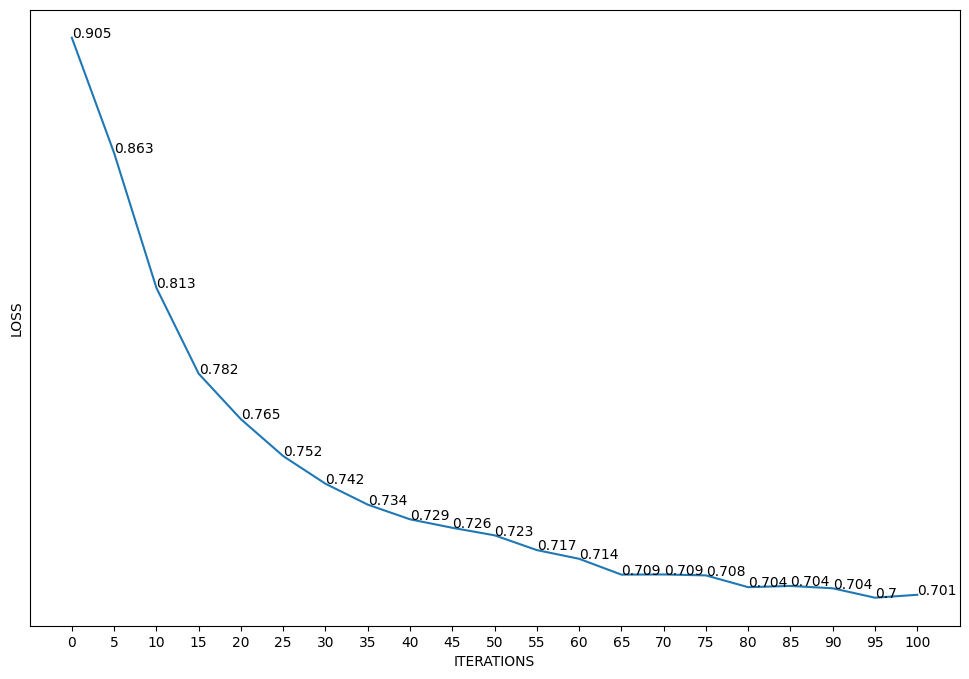

In [ ]:
ys = []
no = 0
li = 5
fig, ax = plt.subplots(figsize=(12,8))
for i in lossArray:
  if no % li == 0:
    ys.append(i)
  no+=1
print(ys)
xs = []
no = 0
while len(xs) < len(ys):
  xs.append(no)
  no += li
plt.xticks(range(0, len(lossArray), li))
plt.yticks([])
plt.ylabel('LOSS')
plt.xlabel('ITERATIONS')
plt.plot(xs, ys)
for index in range(len(xs)):
  ax.text(xs[index], ys[index], round(ys[index], 3))
plt.show()

21


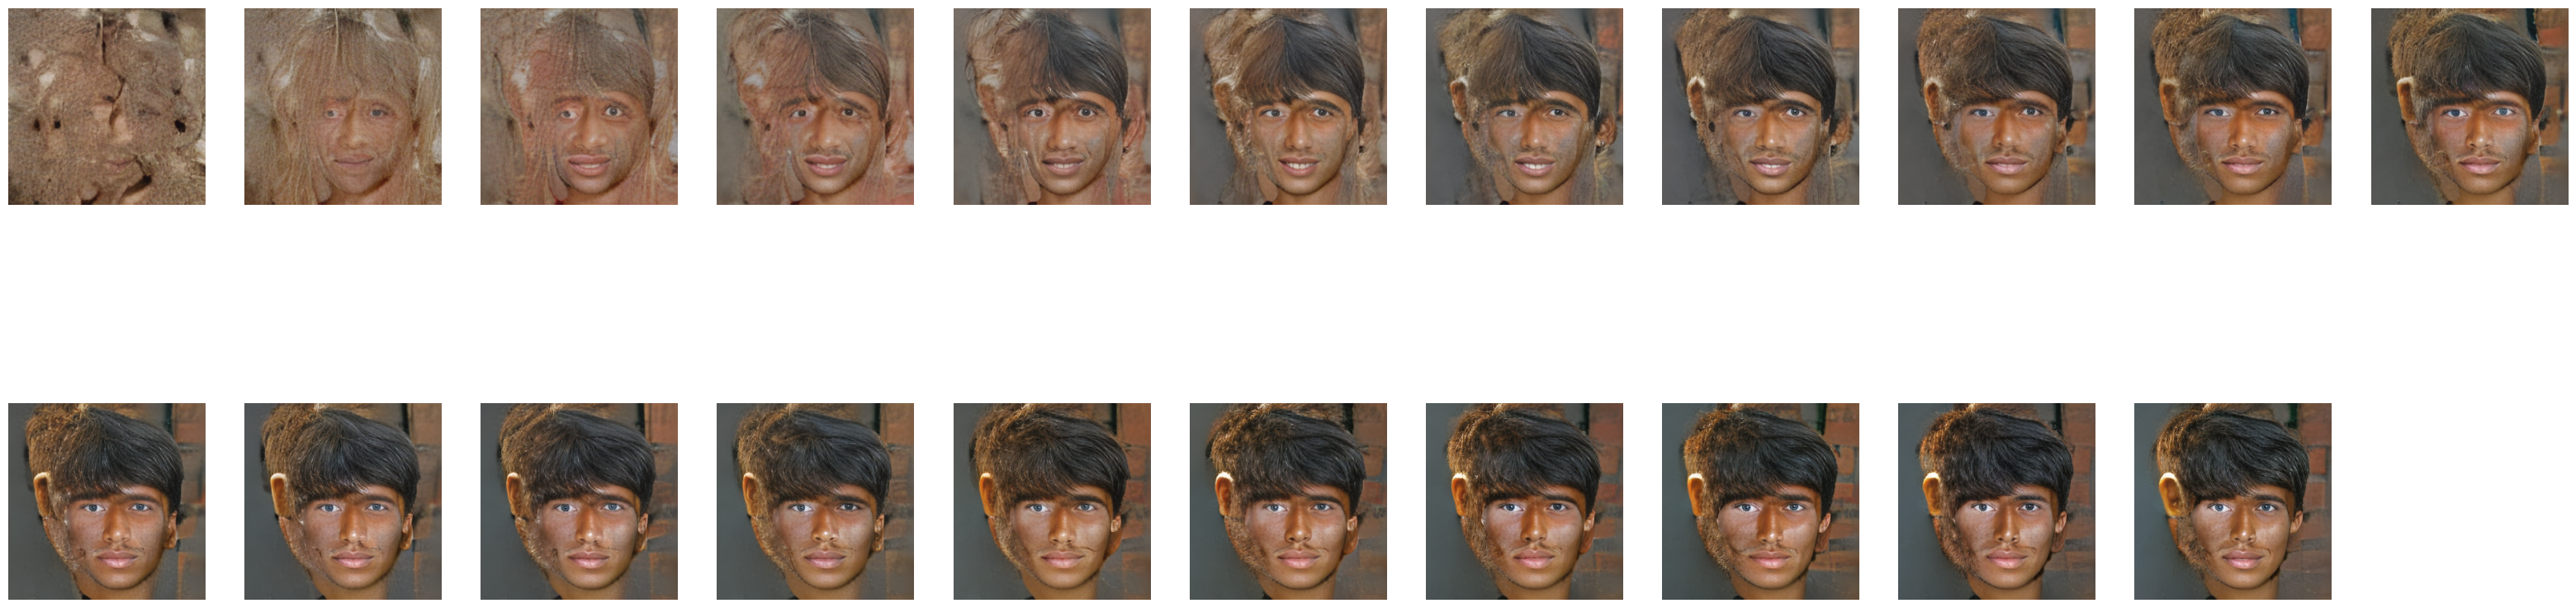

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
count = 0
images1 = []
imgno = 0
for filename in os.listdir("steps/"):
  if imgno % 5 == 0:
    img_path = f"/content/steps/{(imgno):04}.png"
    images1.append(mpimg.imread(img_path)) #read an image from file into array. Returns the image data
  imgno+=1
print(len(images1))

plt.figure(figsize=(40,30))
columns = 11
for i, image in enumerate(images1):
    plt.subplot(int(len(images1) / columns + 4), columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

Store the images into google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/steps/ /content/drive/MyDrive/GANRES/

In [2]:
!pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=f4f7856c0691838c9084f4b9c4e7c1a372253cb7b8f5d29905dd74781f1cb3ad
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [10]:
!pipreqs . --force

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
